In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [110]:
import nltk
import os
from pprint import pprint

# 1.1 Working with a corpus

Let's scale up from the individual text to whole collections. The term "corpus" is commonly used in text analysis. 

The concept of a **corpus** is helpful because it refers not just to a bunch of texts, but also points to the act of purposeful aggregation that brought those texts together. For example, we use the term "corpus" to refer to the collected works of a particular author. For your research, you may aggregate a corpus based on thematic or temporal criteria which are informed by your research questions and theoretical assumptions. When analyzing a corpus, or interpreting the results of such an analysis, it is important to keep in mind its provenance -- not just its contents.

In [3]:
text_root = '/Users/erickpeirson/EmbryoProjectTexts/files'

try:
    assert os.path.exists(text_root)
except AssertionError:
    print "That directory doesn't exist!"

In [37]:
corpus = nltk.corpus.PlaintextCorpusReader(text_root, 'https.+')

In [38]:
corpus.words()

[u'By', u'Mandana', u'Minai', u'Published', u':', ...]

## Normalization and Filtering

We'll use the normalization and filtering procedures from our last notebook. The code-cell below sets up the functions that we defined earlier.

In [49]:
wordnet = nltk.WordNetLemmatizer()
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

def normalize_token(token):
    """
    Convert token to lowercase, and stem using the Porter algorithm.
    
    Parameters
    ----------
    token : str
    
    Returns
    -------
    token : str
    """
    return wordnet.lemmatize(token.lower())

def filter_token(token):
    """
    Evaluate whether or not to retain ``token``.
    
    Parameters
    ----------
    token : str
    
    Returns
    -------
    keep : bool
    """
    token = token.lower()
    return token not in stoplist and token.isalpha() and len(token) > 2

## Simple frequency distributions

We can get the frequency of tokens in our corpus just like we did for a single text, using a [``FreqDist``](http://www.nltk.org/api/nltk.html#nltk.probability.FreqDist) (frequency distribution). 

In NLTK, frequencies and probabilities are usually discussed in terms of "experiments". A frequency distribution records the frequency of specific outcomes (**samples**) of a repeated experiment. In this case, we are sampling tokens from a text.

In [60]:
word_counts = nltk.FreqDist([normalize_token(token) 
                             for token in corpus.words() 
                             if filter_token(token)])

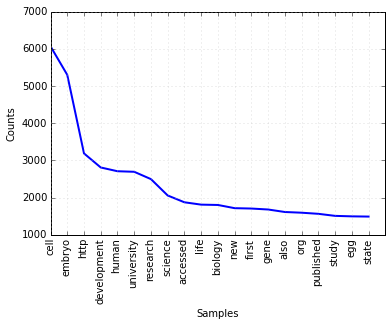

In [61]:
word_counts.plot(20)

In [117]:
document_counts = nltk.FreqDist([
    token    # Each token will be counted a maximum of 1 time per text.
    for fileid in corpus.fileids() 
    for token in set(    # There can be no duplicates in a set.
        [normalize_token(token)    # Normalize first!
         for token 
         in corpus.words(fileids=[fileid])
         if filter_token(token)]
    )
])

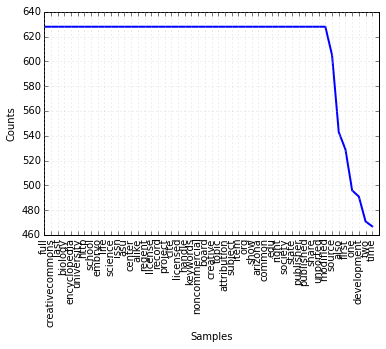

In [118]:
document_counts.plot(50)

In the figure above, we can see that the top ~40 words occur in around 630 texts. We can see precise values using the ``most_common()`` function:

In [120]:
document_counts.most_common(10)    # Get the 10 most common words.

[(u'full', 628),
 (u'creativecommons', 628),
 (u'last', 628),
 (u'biology', 628),
 (u'encyclopedia', 628),
 (u'university', 628),
 (u'http', 628),
 (u'school', 628),
 (u'embryo', 628),
 (u'life', 628)]

It can be useful to examine the number of texts in which a word occurs, to get a better picture of its distribution over the corpus. We can use a ``FreqDist`` for this, too.

We modify our logic slightly: for each document, we conver the list of normalized/filtered tokens into a **set**. This means that each word will be counted only once per text, even if several tokens are present.

It turns out that there are 628 texts in this corpus...

So these are words that occur in every single text in the corpus.

In [119]:
len(corpus.fileids())

628

## Metadata 

In computational humanities, it is very unusual to analyze a corpus without reference to at least some minimal metadata. The Python package called [``Tethne``](http://diging.github.io/tethne/) provides some useful mechanisms for importing metadata from Zotero RDF and other bibliographic formats.

In [ ]:
from tethne.readers import zotero
zotero_export_path = '/Users/erickpeirson/EmbryoProjectTexts'
metadata = zotero.read(zotero_export_path, index_by='link', follow_links=False)

Since we indexed our metadata using the "link" field, we can look up metadata for each text using its ``fileid``.

In [116]:
example_fileid = corpus.fileids()[0]
print 'This is the fileid:', example_fileid, '\n'
print 'This is the metadata for this fileid:', '\n'
pprint(metadata[example_fileid].__dict__)   # pprint means "pretty print".

This is the fileid: https--____hpsrepository.asu.edu__handle__10776__11335.txt 

This is the metadata for this fileid: 

{'authors_full': [(u'MINAI', u'MANDANA')],
 'date': 2016,
 'documentType': u'journalArticle',
 'journal': u'Embryo Project Online Encyclopedia',
 'link': u'/Users/erickpeirson/EmbryoProjectTexts/files/https--____hpsrepository.asu.edu__handle__10776__11335.txt',
 'title': u'Methylmercury and Human Embryonic Development',
 'uri': u'https://hpsrepository.asu.edu/handle/10776/11335'}


### Conditional Frequencies

We can use metadata to add dimensionality to our texts. To examine the distribution of a token over time, we can use a [``ConditionalFreqDist``](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalFreqDist) (conditional frequency distribution). Just like the ``FreqDist``, the ``ConditionalFreqDist`` records the outcomes (samples) of an experiment. A ``ConditionalFreqDist`` also records a label, or **condition**, for each outcome.

In the example below, we examine the word usage of different authors. The **conditions** are the author names, and the **samples** are tokens. We will limit our analysis to four specific tokens: ``'organism', 'ivf', 'pluripotent', 'supreme'`` (doing this for all tokens would be pretty costly).

In [128]:
focal_tokens = ['organism', 'ivf', 'pluripotent', 'supreme']

authorDist = nltk.ConditionalFreqDist([
        (str(author[0]), normalize_token(token))    # (condition, sample)
         for fileid in corpus.fileids()
         for token in corpus.words(fileids=[fileid])
         for author in metadata[fileid].authors
         if filter_token(token)
            and normalize_token(token) in focal_tokens
    ])

In [129]:
authorDist.tabulate()

                                      ivf organism pluripotent supreme 
      (u"BRIND'AMOUR", u'KATHERINE')    1    1   11    2 
              (u"O'BRIEN", u'CEARA')    5    0    1    1 
          (u"O'CONNELL", u'LINDSEY')    0   13    0    0 
          (u"O'CONNOR", u'KATHLEEN')    0    2    0    1 
              (u"O'NEIL", u' ERICA')    0    1    0    0 
               (u"O'NEIL", u'ERICA')    0    1    0    1 
              (u'ABBOUD', u'ALEXIS')    0    6    0    2 
              (u'ANDREI', u'AMANDA')    0    6    0    0 
          (u'ANTONIOS', u'NATHALIE')    4    0    0   19 
          (u'APPLETON', u'CAROLINE')    6    5    0    0 
          (u'ASTON', u'S ALEXANDRA')    0    8    0    0 
             (u'BARANSKI', u'MARCI')    0    4    0    0 
         (u'BARNES', u'M ELIZABETH')    0  108    0    0 
              (u'BARTLETT', u'ZANE')    0   18   26    0 
                (u'BRIGGS', u'JILL')    0    1    0    1 
               (u'BRINKMAN', u'JOE')    0   14    0    0 


### Words over time

We can also use a ``ConditionalFreqDist`` to see how tokens are distributed over time. This works just like the distribution of words over authors, except that in this case we will treat our tokens as conditions. Think of it like this: each time we encounter one of the tokens in our list of focal tokens (conditions), we sample the publication date of the text from which it was drawn.

In [130]:
focal_tokens = ['organism', 'ivf', 'pluripotent', 'supreme']
timeDist = nltk.ConditionalFreqDist([
        (normalize_token(token), metadata[fileid].date)
         for fileid in corpus.fileids()
         for token in corpus.words(fileids=[fileid])
         if filter_token(token)
            and normalize_token(token) in focal_tokens
    ])

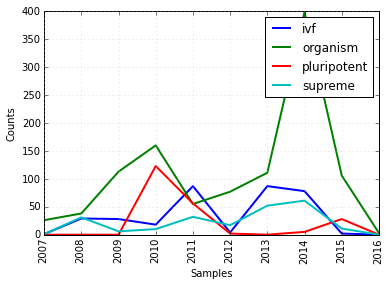

In [59]:
timeDist.plot()